In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, log_loss
from sklearn.calibration import calibration_curve
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

pd.set_option('display.max_columns', None)

df = pd.read_csv('stay_reg_time_standardized_data.csv', sep=',')

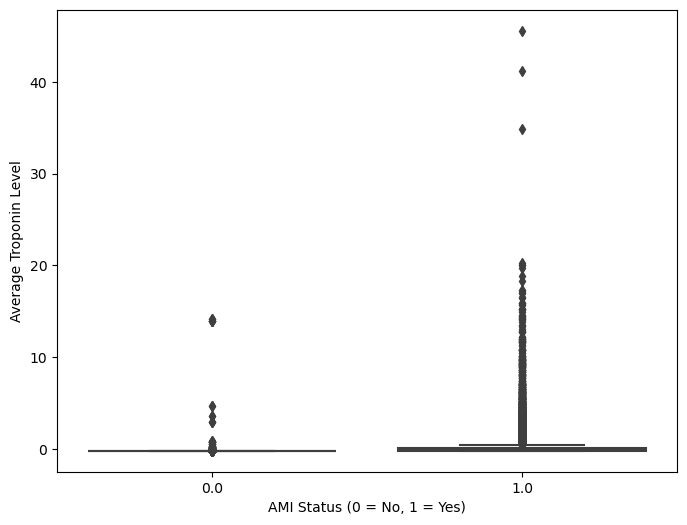

In [2]:
# EDA 

# Distribution of troponin levels by AMI status
plt.figure(figsize=(8, 6))
sns.boxplot(data=df, x='AMI_No_AMI', y='average_troponin_level')
plt.xlabel('AMI Status (0 = No, 1 = Yes)')
plt.ylabel('Average Troponin Level')
plt.savefig('troponin_levels_by_ami_status.png', format='png', dpi=300)
plt.show()

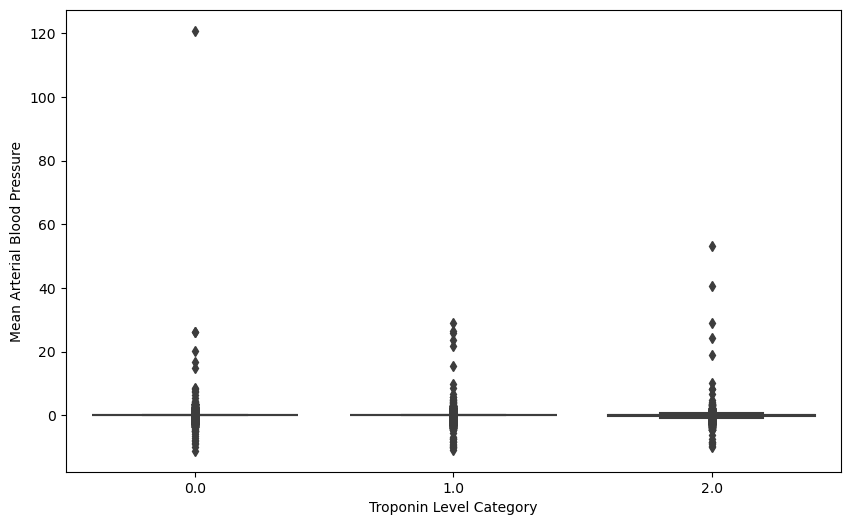

In [3]:
# Plot a box plot of troponin level category vs. blood pressure 
plt.figure(figsize=(10, 6))
sns.boxplot(y='avg_abpm', x='average_troponin_level_category_numeric', data=df)
plt.xlabel('Troponin Level Category')
plt.ylabel('Mean Arterial Blood Pressure')
plt.savefig('troponin_levels_avg_bp.png', format='png', dpi=300)
plt.show()

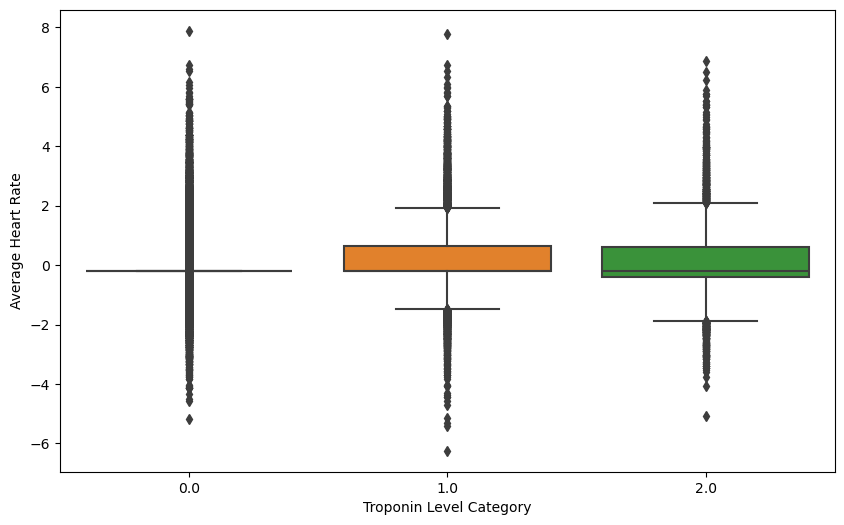

In [4]:
# Plot a box plot of troponin level category vs. average heart rate 
plt.figure(figsize=(10, 6))
sns.boxplot(y='avg_heartv', x='average_troponin_level_category_numeric', data=df)
plt.xlabel('Troponin Level Category')
plt.ylabel('Average Heart Rate')
plt.savefig('troponin_levels_avg_bp.png', format='png', dpi=300)
plt.show()

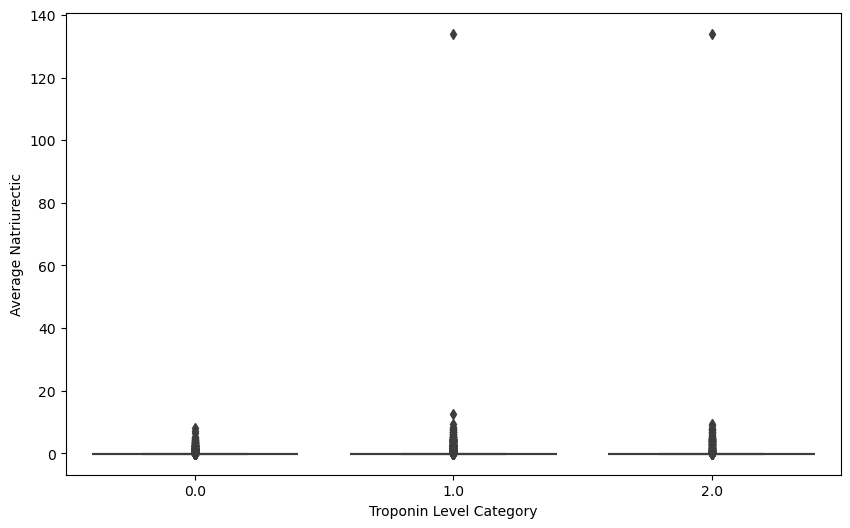

In [5]:
# Plot a box plot of troponin level category vs. natriuretic peptide
plt.figure(figsize=(10, 6))
sns.boxplot(y='avg_natiurectic', x='average_troponin_level_category_numeric', data=df)
plt.xlabel('Troponin Level Category')
plt.ylabel('Average Natriurectic')
plt.savefig('troponin_levels_avg_np.png', format='png', dpi=300)
plt.show()

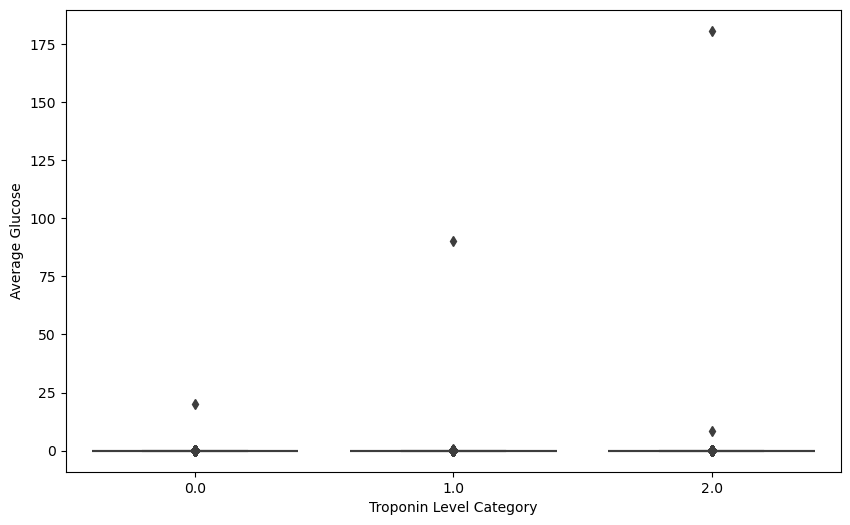

In [6]:
# Plot a box plot of troponin level category vs. glucose
plt.figure(figsize=(10, 6))
sns.boxplot(y='avg_glucose', x='average_troponin_level_category_numeric', data=df)
plt.xlabel('Troponin Level Category')
plt.ylabel('Average Glucose')
plt.savefig('troponin_levels_avg_glu.png', format='png', dpi=300)
plt.show()

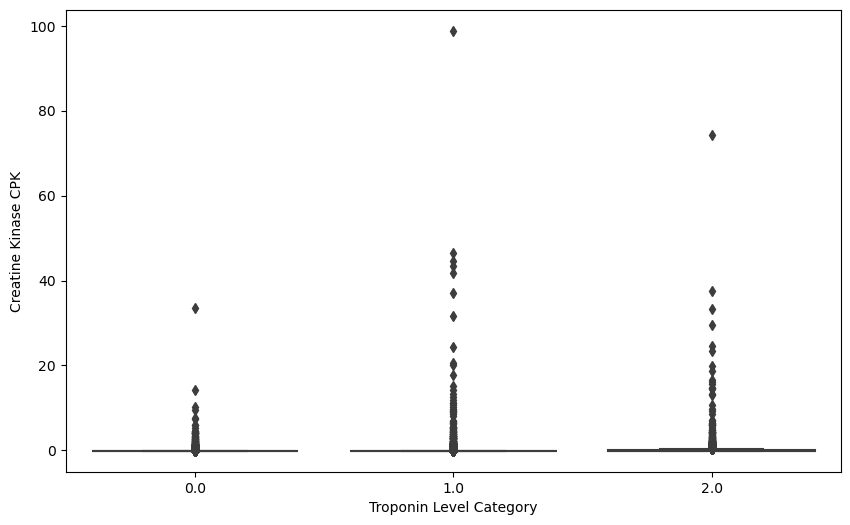

In [7]:
# Plot a box plot of average troponin level vs. creatine kinase cpk
plt.figure(figsize=(10, 6))
sns.boxplot(y='avg_ck_cpk', x='average_troponin_level_category_numeric', data=df)
plt.ylabel('Creatine Kinase CPK')
plt.xlabel('Troponin Level Category')
plt.savefig('troponin_levels_avg_ckcpk.png', format='png', dpi=300)
plt.show()

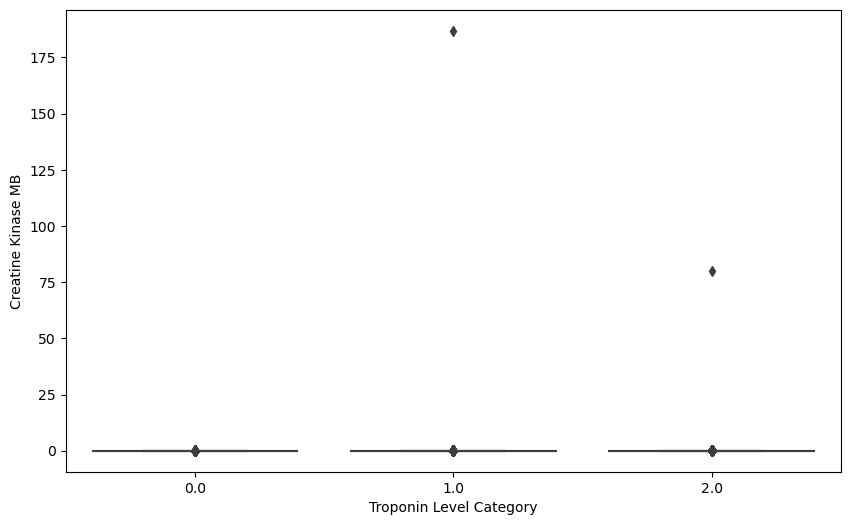

In [8]:
# Plot a box plot of average troponin level vs. creatine kinase mb
plt.figure(figsize=(10, 6))
sns.boxplot(y='avg_ck_mb', x='average_troponin_level_category_numeric', data=df)
plt.ylabel('Creatine Kinase MB')
plt.xlabel('Troponin Level Category')
plt.savefig('troponin_levels_avg_ckmb.png', format='png', dpi=300)
plt.show()

In [9]:
# Convert 'admittime' to datetime
df['admittime'] = pd.to_datetime(df['admittime'], utc=True)

# Convert 'charttime' to datetime
df['charttime'] = pd.to_datetime(df['charttime'], utc=True)

# Calculate the difference in time
df['time_diff_admit_chart'] = df['charttime'] - df['admittime']

# Threshold for time difference (in hours)
threshold_hours = 2
threshold_timedelta = pd.Timedelta(hours=threshold_hours)

# Count rows with time difference < threshold and AMI (AMI_No_AMI = 1)
less_than_ami = df[(df['time_diff_admit_chart'] < threshold_timedelta) & (df['AMI_No_AMI'] == 1)].shape[0]

# Count rows with time difference >= threshold and AMI (AMI_No_AMI = 1)
greater_equal_ami = df[(df['time_diff_admit_chart'] >= threshold_timedelta) & (df['AMI_No_AMI'] == 1)].shape[0]

# print(df.head())

print(f"Number of patients with time difference < {threshold_hours} hours and AMI: {less_than_ami}")
print(f"Number of patients with time difference >= {threshold_hours} hours and AMI: {greater_equal_ami}")

# Drop admittime, charttime and storetime
df = df.drop(['admittime', 'charttime', 'storetime', 'time_diff_admit_chart'], axis=1)

# df_standardised = df.copy()

# # Transform time_diff_admit_chart to hours
# df_standardised['time_diff_admit_chart'] = df_standardised['time_diff_admit_chart'].dt.total_seconds() / 3600

# # Handle missing values with flag imputation
# df_standardised['time_diff_admit_chart'].fillna(-999, inplace=True)

# # Standardise time_diff_admit_chart
# df_standardised['time_diff_admit_chart'] = (df_standardised['time_diff_admit_chart'] - df_standardised['time_diff_admit_chart'].mean()) / df_standardised['time_diff_admit_chart'].std()

Number of patients with time difference < 2 hours and AMI: 3458
Number of patients with time difference >= 2 hours and AMI: 14270


In [10]:
# Number of patient with and without AMI
ami_count = df['AMI_No_AMI'].value_counts().get(1, 0)
no_ami_count = df['AMI_No_AMI'].value_counts().get(0, 0)

print(f'Total AMI: {ami_count}, Total No AMI: {no_ami_count}')

print(f'Total AMI_No_AMI: {len(df)}')

Total AMI: 17881, Total No AMI: 23489
Total AMI_No_AMI: 41370


In [11]:
# Summary statistics
summary = df.describe()

print(summary)

         subject_id       hadm_id     stay_time         Death      reg_time  \
count  4.137000e+04  4.137000e+04  4.137000e+04  41370.000000  4.137000e+04   
mean   1.498479e+07  2.500786e+07  3.452238e-17      0.075780  2.438895e-17   
std    2.886155e+06  2.876715e+06  1.000000e+00      0.264648  1.000000e+00   
min    1.000008e+07  2.000009e+07 -7.226749e-01      0.000000 -3.499042e+00   
25%    1.246344e+07  2.251127e+07 -5.174895e-01      0.000000 -8.966509e-01   
50%    1.497469e+07  2.501861e+07 -2.993146e-01      0.000000 -1.486396e-01   
75%    1.747799e+07  2.748452e+07  1.045722e-01      0.000000  3.036099e-01   
max    1.999999e+07  2.999967e+07  2.958036e+01      1.000000  2.387535e+01   

       hospital_expire_flag  average_troponin_level  average_cholesterol_HDL  \
count          41370.000000            4.137000e+04             4.137000e+04   
mean               0.075852            9.588119e-17            -5.423964e-16   
std                0.264764            1.000000e

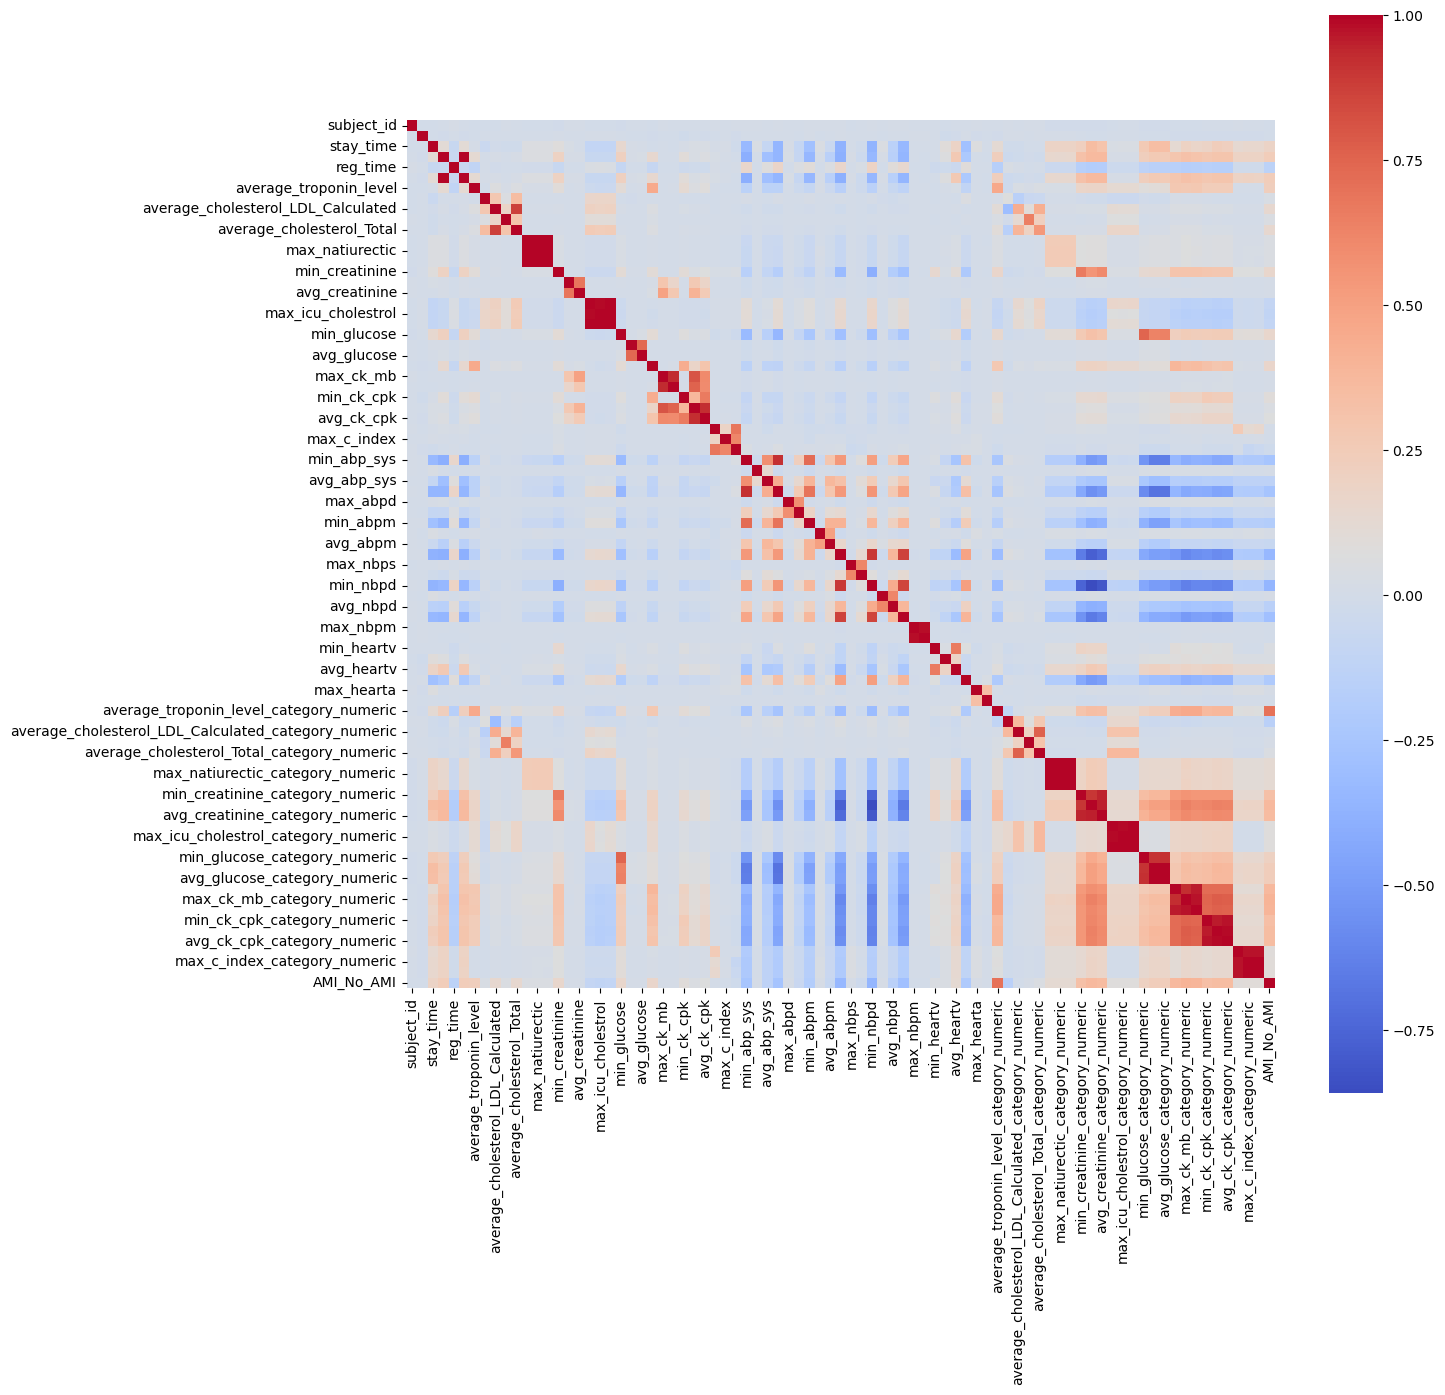

In [12]:
correlation_matrix = df.corr()

plt.figure(figsize=(14,14))
sns.heatmap(correlation_matrix, fmt='.2f', cmap='coolwarm', square=True)
# annot=True
plt.show()

In [13]:
label_correlation = correlation_matrix['AMI_No_AMI']
pd.set_option('display.max_rows', None)

print(label_correlation)

subject_id                                            -0.003038
hadm_id                                               -0.005444
stay_time                                              0.181798
Death                                                  0.244666
reg_time                                              -0.134600
hospital_expire_flag                                   0.244689
average_troponin_level                                 0.229089
average_cholesterol_HDL                                0.027134
average_cholesterol_LDL_Calculated                     0.140461
average_cholesterol_LDL_Measured                       0.045224
average_cholesterol_Total                              0.136601
min_natiurectic                                        0.041710
max_natiurectic                                        0.042625
avg_natiurectic                                        0.042175
min_creatinine                                         0.157514
max_creatinine                          

In [14]:
abs_correlations = label_correlation.abs()

rounded_correlations = abs_correlations.round(2)

# Select features with correlation >= 0.2
high_correlations = rounded_correlations[rounded_correlations >= 0.2]

print("Features with correlation >= 0.2 with AMI_No_AMI (rounded):")
features = list(high_correlations.keys())
features.remove("AMI_No_AMI")
print(features)

Features with correlation >= 0.2 with AMI_No_AMI (rounded):
['Death', 'hospital_expire_flag', 'average_troponin_level', 'min_abp_sys', 'min_abpd', 'min_nbps', 'min_nbpd', 'min_nbpm', 'min_hearta', 'average_troponin_level_category_numeric', 'min_creatinine_category_numeric', 'max_creatinine_category_numeric', 'avg_creatinine_category_numeric', 'min_glucose_category_numeric', 'max_glucose_category_numeric', 'avg_glucose_category_numeric', 'min_ck_mb_category_numeric', 'max_ck_mb_category_numeric', 'avg_ck_mb_category_numeric', 'min_ck_cpk_category_numeric', 'max_ck_cpk_category_numeric', 'avg_ck_cpk_category_numeric']


In [15]:
X = df[features]
y = df['AMI_No_AMI']
X_train, X_rem, y_train, y_rem = train_test_split(X,y, train_size=0.8, stratify=y)#80%train 20%rem
X_valid, X_test, y_valid, y_test = train_test_split(X_rem,y_rem, test_size=0.5, stratify=y_rem)#10%val 10%test

In [16]:
K = [3, 5, 7, 9, 11, 13, 15, 17, 19]
weight = ['uniform', 'distance']
p_value = [1, 2] # 1 for Manhattan, 2 for Euclidean distance
best_acc = 0
for i in weight:
    for p in p_value:
        for k in K:
            knn = KNeighborsClassifier(n_neighbors=k, 
                                       weights=i, 
                                       p=p)
            knn.fit(X_train, y_train)
            y_pred_knn = knn.predict(X_valid)
            print("weight: ", i)
            if (p==1):
                print("distance function: Manhattan")
            else:
                print("distance function: Euclidean")
            print("K: ", k)
            accuracy = accuracy_score(y_valid, y_pred_knn)
            print("accuracy: ", accuracy)
            if (accuracy >= best_acc):
                best_acc = accuracy
                best_weight = i
                best_p = p
                best_k = k
            
            print("\n")

weight:  uniform
distance function: Manhattan
K:  3
accuracy:  0.9059705100314237


weight:  uniform
distance function: Manhattan
K:  5
accuracy:  0.9095963258399806


weight:  uniform
distance function: Manhattan
K:  7
accuracy:  0.911530094271211


weight:  uniform
distance function: Manhattan
K:  9
accuracy:  0.9100797679477882


weight:  uniform
distance function: Manhattan
K:  11
accuracy:  0.9095963258399806


weight:  uniform
distance function: Manhattan
K:  13
accuracy:  0.909112883732173


weight:  uniform
distance function: Manhattan
K:  15
accuracy:  0.9124969784868262


weight:  uniform
distance function: Manhattan
K:  17
accuracy:  0.9110466521634034


weight:  uniform
distance function: Manhattan
K:  19
accuracy:  0.9108049311094997


weight:  uniform
distance function: Euclidean
K:  3
accuracy:  0.9071791153009428


weight:  uniform
distance function: Euclidean
K:  5
accuracy:  0.9086294416243654


weight:  uniform
distance function: Euclidean
K:  7
accuracy:  0.90669567

w:  distance p:  1 k:  17


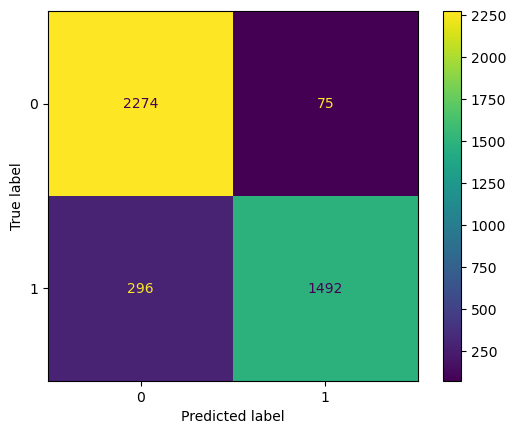

KNN Classification Report:
               precision    recall  f1-score   support

         0.0       0.88      0.97      0.92      2349
         1.0       0.95      0.83      0.89      1788

    accuracy                           0.91      4137
   macro avg       0.92      0.90      0.91      4137
weighted avg       0.91      0.91      0.91      4137

KNN ROC-AUC Score:  0.9458015834240475
KNN Log Loss: 0.315165323253483


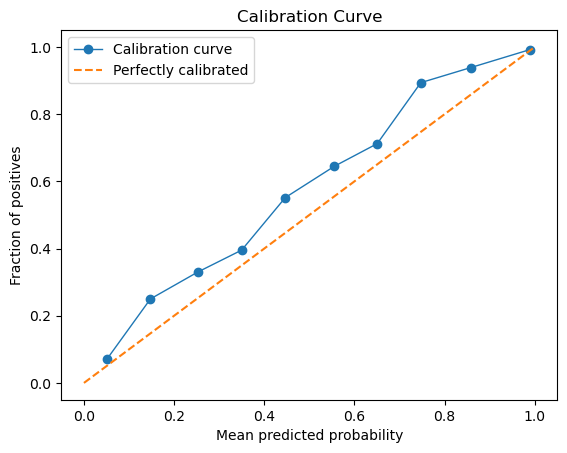

In [17]:
print("w: ", best_weight, "p: ", best_p, "k: ", best_k)
knn_best = KNeighborsClassifier(n_neighbors=best_k, 
                                weights=best_weight, 
                                p=best_p)
knn_best.fit(X_train, y_train)
y_pred_knn = knn_best.predict(X_test)

confusion_matrix = metrics.confusion_matrix(y_test, y_pred_knn)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [0, 1])
cm_display.plot()
plt.show()

print("KNN Classification Report:\n", classification_report(y_test, y_pred_knn))
print("KNN ROC-AUC Score: ", roc_auc_score(y_test, knn_best.predict_proba(X_test)[:, 1]))
print("KNN Log Loss:", log_loss(y_test, knn_best.predict_proba(X_test)[:, 1]))

prob_true, prob_pred = calibration_curve(y_test, knn_best.predict_proba(X_test)[:, 1], n_bins=10)

plt.plot(prob_pred, prob_true, marker='o', linewidth=1, label='Calibration curve')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Calibration Curve')
plt.legend()
plt.show()

In [18]:
penalty = ['l1', 'l2', 'elasticnet', 'none']
solver = ['lbfgs', 'liblinear', 'newton-cg', 'sag', 'saga']
ratio = [0, 0.25, 0.5, 0.75, 1]
best_acc = 0

for p in penalty:
    for s in solver:
        if (p in ['l1', 'elasticnet'] and s in ['lbfgs', 'newton-cg', 'newton-cholesky', 'sag']) or \
           (p in ['none', 'elasticnet'] and s == 'liblinear'):
            continue
        if p == 'elasticnet' and s == 'saga':
            for r in ratio:
                lr = LogisticRegression(random_state=42, penalty=p, solver=s, l1_ratio=r)
                lr.fit(X_train, y_train)
                y_pred_lr = lr.predict(X_valid)
                print("penalty: ", p)
                print("solver: ",s)
                print("ratio: ",r)
                accuracy = accuracy_score(y_valid, y_pred_lr)
                print("accuracy: ", accuracy)
                if (accuracy >= best_acc):
                    best_acc = accuracy
                    best_penalty = p
                    best_solver = s
                    best_ratio = r
                print("\n")
            continue
        else:
            lr = LogisticRegression(random_state=42, penalty=p, solver=s)
        lr.fit(X_train, y_train)
        y_pred_lr = lr.predict(X_valid)
        print("penalty: ", p)
        print("solver: ",s)
        accuracy = accuracy_score(y_valid, y_pred_lr)
        print("accuracy: ", accuracy)
        if (accuracy >= best_acc):
            best_acc = accuracy
            best_penalty = p
            best_solver = s
        print("\n")

penalty:  l1
solver:  liblinear
accuracy:  0.8851824993956974




C:\Users\Maxson\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


penalty:  l1
solver:  saga
accuracy:  0.8846990572878898


penalty:  l2
solver:  lbfgs
accuracy:  0.8851824993956974


penalty:  l2
solver:  liblinear
accuracy:  0.8851824993956974


penalty:  l2
solver:  newton-cg
accuracy:  0.8854242204496011




C:\Users\Maxson\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


penalty:  l2
solver:  sag
accuracy:  0.8846990572878898




C:\Users\Maxson\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


penalty:  l2
solver:  saga
accuracy:  0.8849407783417935




C:\Users\Maxson\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


penalty:  elasticnet
solver:  saga
ratio:  0
accuracy:  0.8849407783417935




C:\Users\Maxson\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


penalty:  elasticnet
solver:  saga
ratio:  0.25
accuracy:  0.8849407783417935




C:\Users\Maxson\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


penalty:  elasticnet
solver:  saga
ratio:  0.5
accuracy:  0.8849407783417935




C:\Users\Maxson\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


penalty:  elasticnet
solver:  saga
ratio:  0.75
accuracy:  0.8846990572878898




C:\Users\Maxson\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Maxson\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


penalty:  elasticnet
solver:  saga
ratio:  1
accuracy:  0.8846990572878898


penalty:  none
solver:  lbfgs
accuracy:  0.8846990572878898




C:\Users\Maxson\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


penalty:  none
solver:  newton-cg
accuracy:  0.8846990572878898




C:\Users\Maxson\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\Maxson\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Maxson\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


penalty:  none
solver:  sag
accuracy:  0.8846990572878898


penalty:  none
solver:  saga
accuracy:  0.8849407783417935




C:\Users\Maxson\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


p:  l2 s:  newton-cg


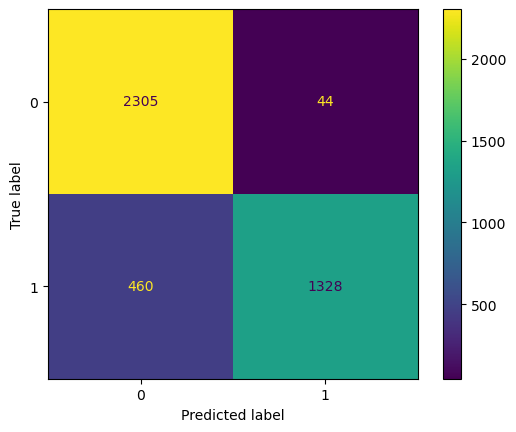

Logistic Regression Classification Report:
               precision    recall  f1-score   support

         0.0       0.83      0.98      0.90      2349
         1.0       0.97      0.74      0.84      1788

    accuracy                           0.88      4137
   macro avg       0.90      0.86      0.87      4137
weighted avg       0.89      0.88      0.88      4137

Logistic Regression ROC-AUC Score:  0.8676393067448378
Logistic Regression Log Loss: 0.3214166423931091


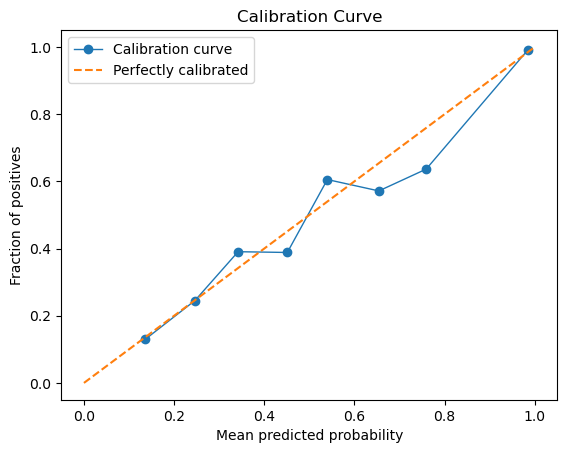

In [19]:
print("p: ", best_penalty, "s: ", best_solver)
if best_penalty == 'elasticnet' and best_solver == 'saga':
    print("r: ", best_ratio)
    lr_best = LogisticRegression(random_state=42, penalty=best_penalty, solver=best_solver, l1_ratio=best_ratio)
else:
    lr_best = LogisticRegression(random_state=42, penalty=best_penalty, solver=best_solver)

lr_best.fit(X_train, y_train)
y_pred_lr = lr_best.predict(X_test)

confusion_matrix = metrics.confusion_matrix(y_test, y_pred_lr)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [0, 1])
cm_display.plot()
plt.show()

print("Logistic Regression Classification Report:\n", classification_report(y_test, y_pred_lr))
print("Logistic Regression ROC-AUC Score: ", roc_auc_score(y_test, lr_best.predict_proba(X_test)[:, 1]))     
print("Logistic Regression Log Loss:", log_loss(y_test, lr_best.predict_proba(X_test)[:, 1]))

prob_true, prob_pred = calibration_curve(y_test, lr_best.predict_proba(X_test)[:, 1], n_bins=10)

plt.plot(prob_pred, prob_true, marker='o', linewidth=1, label='Calibration curve')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Calibration Curve')
plt.legend()
plt.show()

In [20]:
n_estimators = [25, 50, 75, 100]
max_features = ['sqrt', 'log2', None]
min_samples_split = [2, 5, 10] 
best_acc = 0
for i in n_estimators:
    for f in max_features:
        for ss in min_samples_split:
            rf = RandomForestClassifier(random_state=42, 
                                        n_estimators = i, 
                                        max_features = f,
                                        min_samples_split = ss)
            rf.fit(X_train, y_train)
            y_pred_rf = rf.predict(X_valid)
            print("n_estimators: ", i)
            print("max_features: ",f)
            print("min_samples_split: ", ss)
            accuracy = accuracy_score(y_valid, y_pred_rf)
            print("accuracy: ", accuracy)
            if (accuracy >= best_acc):
                best_acc = accuracy
                best_n_estimators = i
                best_max_features = f
                best_min_samples_split = ss
            print("\n")

n_estimators:  25
max_features:  sqrt
min_samples_split:  2
accuracy:  0.9405366207396664


n_estimators:  25
max_features:  sqrt
min_samples_split:  5
accuracy:  0.9407783417935702


n_estimators:  25
max_features:  sqrt
min_samples_split:  10
accuracy:  0.9395697365240513


n_estimators:  25
max_features:  log2
min_samples_split:  2
accuracy:  0.9405366207396664


n_estimators:  25
max_features:  log2
min_samples_split:  5
accuracy:  0.9407783417935702


n_estimators:  25
max_features:  log2
min_samples_split:  10
accuracy:  0.9395697365240513


n_estimators:  25
max_features:  None
min_samples_split:  2
accuracy:  0.9402948996857626


n_estimators:  25
max_features:  None
min_samples_split:  5
accuracy:  0.9400531786318589


n_estimators:  25
max_features:  None
min_samples_split:  10
accuracy:  0.941020062847474


n_estimators:  50
max_features:  sqrt
min_samples_split:  2
accuracy:  0.941020062847474


n_estimators:  50
max_features:  sqrt
min_samples_split:  5
accuracy:  0.939328

n:  100 mf:  log2 mss:  2


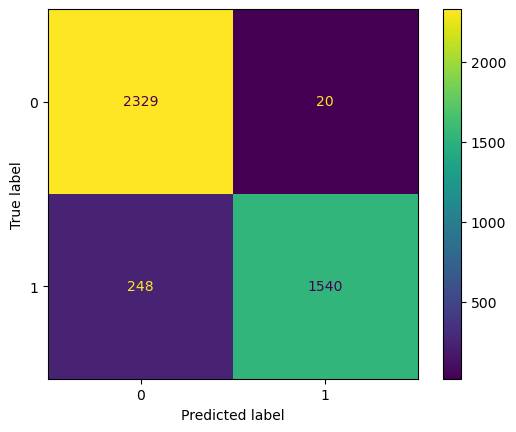

Random Forest Classification Report:
               precision    recall  f1-score   support

         0.0       0.90      0.99      0.95      2349
         1.0       0.99      0.86      0.92      1788

    accuracy                           0.94      4137
   macro avg       0.95      0.93      0.93      4137
weighted avg       0.94      0.94      0.93      4137

Random Forest ROC-AUC Score:  0.9515379956057268
Random Forest Log Loss: 0.2038016560597036


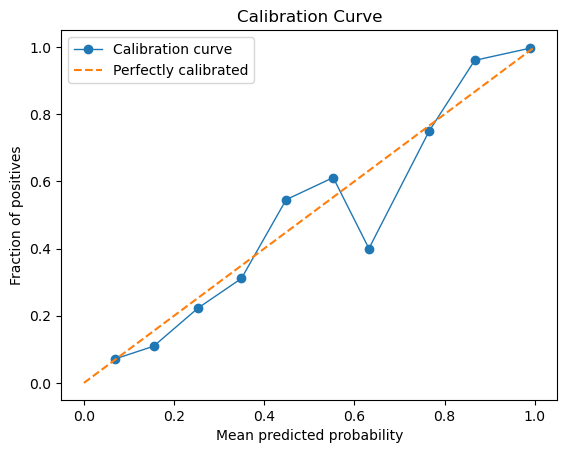

In [21]:
print("n: ", best_n_estimators, "mf: ", best_max_features, "mss: ", best_min_samples_split)
rf_best = RandomForestClassifier(random_state=42, 
                                 n_estimators = best_n_estimators, 
                                 max_features = best_max_features, 
                                 min_samples_split = best_min_samples_split )
rf_best.fit(X_train, y_train)
y_pred_rf = rf_best.predict(X_test)

confusion_matrix = metrics.confusion_matrix(y_test, y_pred_rf)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [0, 1])
cm_display.plot()
plt.show()

print("Random Forest Classification Report:\n", classification_report(y_test, y_pred_rf))
print("Random Forest ROC-AUC Score: ", roc_auc_score(y_test, rf_best.predict_proba(X_test)[:, 1]))
print("Random Forest Log Loss:", log_loss(y_test, rf_best.predict_proba(X_test)[:, 1]))

prob_true, prob_pred = calibration_curve(y_test, rf_best.predict_proba(X_test)[:, 1], n_bins=10)

plt.plot(prob_pred, prob_true, marker='o', linewidth=1, label='Calibration curve')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Calibration Curve')
plt.legend()
plt.show()

# Troponin

In [22]:
label_correlation = correlation_matrix['average_troponin_level_category_numeric']
pd.set_option('display.max_rows', None)

print(label_correlation)

subject_id                                            -0.000517
hadm_id                                               -0.012123
stay_time                                              0.115066
Death                                                  0.228174
reg_time                                              -0.164411
hospital_expire_flag                                   0.228318
average_troponin_level                                 0.462648
average_cholesterol_HDL                                0.013962
average_cholesterol_LDL_Calculated                     0.102674
average_cholesterol_LDL_Measured                       0.038097
average_cholesterol_Total                              0.095240
min_natiurectic                                        0.042847
max_natiurectic                                        0.044083
avg_natiurectic                                        0.043459
min_creatinine                                         0.164234
max_creatinine                          

In [23]:
abs_correlations = label_correlation.abs()

rounded_correlations = abs_correlations.round(2)

# Select features with correlation >= 0.2
high_correlations = rounded_correlations[rounded_correlations >= 0.2]

print("Features with correlation >= 0.2 with average_troponin_level_category_numeric (rounded):")
features = list(high_correlations.keys())
features.remove("AMI_No_AMI")
features.remove("average_troponin_level")
features.remove("average_troponin_level_category_numeric")
print(features)

Features with correlation >= 0.2 with average_troponin_level_category_numeric (rounded):
['Death', 'hospital_expire_flag', 'min_ck_mb', 'min_abp_sys', 'min_abpd', 'min_nbps', 'min_nbpd', 'min_nbpm', 'min_hearta', 'min_creatinine_category_numeric', 'max_creatinine_category_numeric', 'avg_creatinine_category_numeric', 'min_glucose_category_numeric', 'max_glucose_category_numeric', 'avg_glucose_category_numeric', 'min_ck_mb_category_numeric', 'max_ck_mb_category_numeric', 'avg_ck_mb_category_numeric', 'min_ck_cpk_category_numeric', 'max_ck_cpk_category_numeric', 'avg_ck_cpk_category_numeric']


In [24]:
X = df[features]
y = df['average_troponin_level_category_numeric']
X_train, X_rem, y_train, y_rem = train_test_split(X,y, train_size=0.8, stratify=y)#80%train 20%rem
X_valid, X_test, y_valid, y_test = train_test_split(X_rem,y_rem, test_size=0.5, stratify=y_rem)#10%val 10%test

In [25]:
K = [3, 5, 7, 9, 11, 13, 15, 17, 19]
weight = ['uniform', 'distance']
p_value = [1, 2] # 1 for Manhattan, 2 for Euclidean distance
best_acc = 0
for i in weight:
    for p in p_value:
        for k in K:
            knn = KNeighborsClassifier(n_neighbors=k, 
                                       weights=i, 
                                       p=p)
            knn.fit(X_train, y_train)
            y_pred_knn = knn.predict(X_valid)
            print("weight: ", i)
            if (p==1):
                print("distance function: Manhattan")
            else:
                print("distance function: Euclidean")
            print("K: ", k)
            accuracy = accuracy_score(y_valid, y_pred_knn)
            print("accuracy: ", accuracy)
            if (accuracy >= best_acc):
                best_acc = accuracy
                best_weight = i
                best_p = p
                best_k = k
            
            print("\n")

weight:  uniform
distance function: Manhattan
K:  3
accuracy:  0.718153251148175


weight:  uniform
distance function: Manhattan
K:  5
accuracy:  0.7217790669567319


weight:  uniform
distance function: Manhattan
K:  7
accuracy:  0.7304810248972685


weight:  uniform
distance function: Manhattan
K:  9
accuracy:  0.7302393038433648


weight:  uniform
distance function: Manhattan
K:  11
accuracy:  0.7292724196277496


weight:  uniform
distance function: Manhattan
K:  13
accuracy:  0.7302393038433648


weight:  uniform
distance function: Manhattan
K:  15
accuracy:  0.7285472564660382


weight:  uniform
distance function: Manhattan
K:  17
accuracy:  0.728788977519942


weight:  uniform
distance function: Manhattan
K:  19
accuracy:  0.7302393038433648


weight:  uniform
distance function: Euclidean
K:  3
accuracy:  0.7200870195794054


weight:  uniform
distance function: Euclidean
K:  5
accuracy:  0.7212956248489243


weight:  uniform
distance function: Euclidean
K:  7
accuracy:  0.72637176

w:  distance p:  1 k:  15


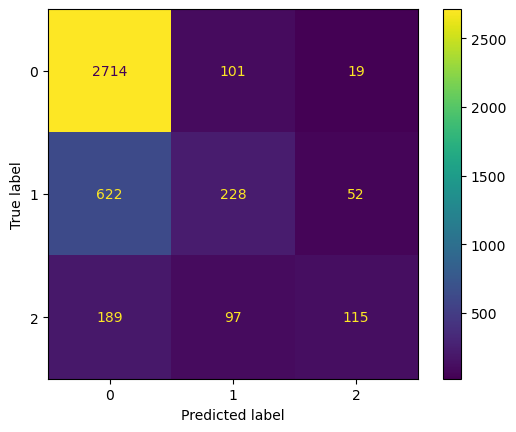

KNN Classification Report:
               precision    recall  f1-score   support

         0.0       0.77      0.96      0.85      2834
         1.0       0.54      0.25      0.34       902
         2.0       0.62      0.29      0.39       401

    accuracy                           0.74      4137
   macro avg       0.64      0.50      0.53      4137
weighted avg       0.70      0.74      0.70      4137

KNN ROC-AUC Score:  0.6717407194731867
KNN Log Loss: 0.9651665231640999


In [26]:
print("w: ", best_weight, "p: ", best_p, "k: ", best_k)
knn_best = KNeighborsClassifier(n_neighbors=best_k, 
                                weights=best_weight, 
                                p=best_p)
knn_best.fit(X_train, y_train)
y_pred_knn = knn_best.predict(X_test)

confusion_matrix = metrics.confusion_matrix(y_test, y_pred_knn)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [0,1,2])
cm_display.plot()
plt.show()

print("KNN Classification Report:\n", classification_report(y_test, y_pred_knn))
print("KNN ROC-AUC Score: ", roc_auc_score(y_test, knn_best.predict_proba(X_test), multi_class = 'ovo'))
print("KNN Log Loss:", log_loss(y_test, knn_best.predict_proba(X_test)))

In [27]:
penalty = ['l1', 'l2', 'elasticnet', 'none']
solver = ['lbfgs', 'liblinear', 'newton-cg', 'sag', 'saga']
ratio = [0, 0.25, 0.5, 0.75, 1]
best_acc = 0

for p in penalty:
    for s in solver:
        if (p in ['l1', 'elasticnet'] and s in ['lbfgs', 'newton-cg', 'newton-cholesky', 'sag']) or \
           (p in ['none', 'elasticnet'] and s == 'liblinear'):
            continue
        if p == 'elasticnet' and s == 'saga':
            for r in ratio:
                lr = LogisticRegression(random_state=42, penalty=p, solver=s, l1_ratio=r, multi_class='auto')
                lr.fit(X_train, y_train)
                y_pred_lr = lr.predict(X_valid)
                print("penalty: ", p)
                print("solver: ",s)
                print("ratio: ",r)
                accuracy = accuracy_score(y_valid, y_pred_lr)
                print("accuracy: ", accuracy)
                if (accuracy >= best_acc):
                    best_acc = accuracy
                    best_penalty = p
                    best_solver = s
                    best_ratio = r
                print("\n")
            continue
        else:
            lr = LogisticRegression(random_state=42, penalty=p, solver=s)
        lr.fit(X_train, y_train)
        y_pred_lr = lr.predict(X_valid)
        print("penalty: ", p)
        print("solver: ",s)
        accuracy = accuracy_score(y_valid, y_pred_lr)
        print("accuracy: ", accuracy)
        if (accuracy >= best_acc):
            best_acc = accuracy
            best_penalty = p
            best_solver = s
        print("\n")

penalty:  l1
solver:  liblinear
accuracy:  0.7379743775682862




C:\Users\Maxson\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


penalty:  l1
solver:  saga
accuracy:  0.7372492144065748




C:\Users\Maxson\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


penalty:  l2
solver:  lbfgs
accuracy:  0.7374909354604786


penalty:  l2
solver:  liblinear
accuracy:  0.7374909354604786


penalty:  l2
solver:  newton-cg
accuracy:  0.7374909354604786




C:\Users\Maxson\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


penalty:  l2
solver:  sag
accuracy:  0.7384578196760938




C:\Users\Maxson\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


penalty:  l2
solver:  saga
accuracy:  0.7374909354604786




C:\Users\Maxson\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


penalty:  elasticnet
solver:  saga
ratio:  0
accuracy:  0.7374909354604786




C:\Users\Maxson\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


penalty:  elasticnet
solver:  saga
ratio:  0.25
accuracy:  0.7377326565143824




C:\Users\Maxson\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


penalty:  elasticnet
solver:  saga
ratio:  0.5
accuracy:  0.7374909354604786




C:\Users\Maxson\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


penalty:  elasticnet
solver:  saga
ratio:  0.75
accuracy:  0.7374909354604786




C:\Users\Maxson\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Maxson\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


penalty:  elasticnet
solver:  saga
ratio:  1
accuracy:  0.7372492144065748




C:\Users\Maxson\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Maxson\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


penalty:  none
solver:  lbfgs
accuracy:  0.7374909354604786


penalty:  none
solver:  newton-cg
accuracy:  0.7372492144065748




C:\Users\Maxson\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\Maxson\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Maxson\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


penalty:  none
solver:  sag
accuracy:  0.73821609862219


penalty:  none
solver:  saga
accuracy:  0.7374909354604786




C:\Users\Maxson\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


p:  l2 s:  sag


C:\Users\Maxson\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


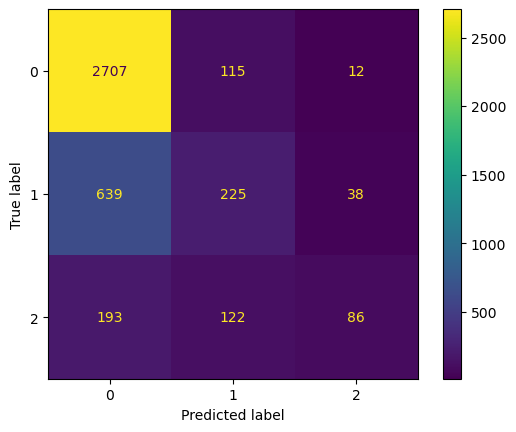

Logistic Regression Classification Report:
               precision    recall  f1-score   support

         0.0       0.76      0.96      0.85      2834
         1.0       0.49      0.25      0.33       902
         2.0       0.63      0.21      0.32       401

    accuracy                           0.73      4137
   macro avg       0.63      0.47      0.50      4137
weighted avg       0.69      0.73      0.68      4137

Logistic Regression ROC-AUC Score:  0.6796579243618114
Logistic Regression Log Loss: 0.6959320906410216


In [28]:
print("p: ", best_penalty, "s: ", best_solver)
if best_penalty == 'elasticnet' and best_solver == 'saga':
    print("r: ", best_ratio)
    lr_best = LogisticRegression(random_state=42, penalty=best_penalty, solver=best_solver, l1_ratio=best_ratio, 
                                 multi_class='auto')
else:
    lr_best = LogisticRegression(random_state=42, penalty=best_penalty, solver=best_solver, multi_class='auto')

lr_best.fit(X_train, y_train)
y_pred_lr = lr_best.predict(X_test)

confusion_matrix = metrics.confusion_matrix(y_test, y_pred_lr)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [0,1,2])
cm_display.plot()
plt.show()

print("Logistic Regression Classification Report:\n", classification_report(y_test, y_pred_lr))
print("Logistic Regression ROC-AUC Score: ", roc_auc_score(y_test, lr_best.predict_proba(X_test), multi_class = 'ovo'))     
print("Logistic Regression Log Loss:", log_loss(y_test, lr_best.predict_proba(X_test)))

In [29]:
n_estimators = [25, 50, 75, 100]
max_features = ['sqrt', 'log2', None]
min_samples_split = [2, 5, 10] 
best_acc = 0
for i in n_estimators:
    for f in max_features:
        for ss in min_samples_split:
            rf = RandomForestClassifier(random_state=42, 
                                        n_estimators = i, 
                                        max_features = f,
                                        min_samples_split = ss)
            rf.fit(X_train, y_train)
            y_pred_rf = rf.predict(X_valid)
            print("n_estimators: ", i)
            print("max_features: ",f)
            print("min_samples_split: ", ss)
            accuracy = accuracy_score(y_valid, y_pred_rf)
            print("accuracy: ", accuracy)
            if (accuracy >= best_acc):
                best_acc = accuracy
                best_n_estimators = i
                best_max_features = f
                best_min_samples_split = ss
            print("\n")

n_estimators:  25
max_features:  sqrt
min_samples_split:  2
accuracy:  0.7360406091370558


n_estimators:  25
max_features:  sqrt
min_samples_split:  5
accuracy:  0.7379743775682862


n_estimators:  25
max_features:  sqrt
min_samples_split:  10
accuracy:  0.7413584723229393


n_estimators:  25
max_features:  log2
min_samples_split:  2
accuracy:  0.7360406091370558


n_estimators:  25
max_features:  log2
min_samples_split:  5
accuracy:  0.7379743775682862


n_estimators:  25
max_features:  log2
min_samples_split:  10
accuracy:  0.7413584723229393


n_estimators:  25
max_features:  None
min_samples_split:  2
accuracy:  0.7331399564902102


n_estimators:  25
max_features:  None
min_samples_split:  5
accuracy:  0.7336233985980178


n_estimators:  25
max_features:  None
min_samples_split:  10
accuracy:  0.7331399564902102


n_estimators:  50
max_features:  sqrt
min_samples_split:  2
accuracy:  0.7353154459753445


n_estimators:  50
max_features:  sqrt
min_samples_split:  5
accuracy:  0.7399

n:  100 mf:  log2 mss:  10


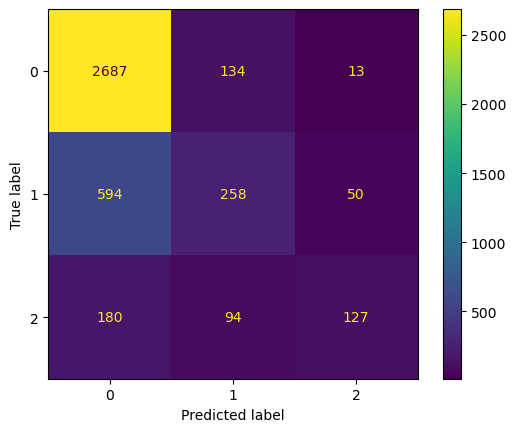

Random Forest Classification Report:
               precision    recall  f1-score   support

         0.0       0.78      0.95      0.85      2834
         1.0       0.53      0.29      0.37       902
         2.0       0.67      0.32      0.43       401

    accuracy                           0.74      4137
   macro avg       0.66      0.52      0.55      4137
weighted avg       0.71      0.74      0.71      4137

Random Forest ROC-AUC Score:  0.7035956505930875
Random Forest Log Loss: 0.6813232310437028


In [30]:
print("n: ", best_n_estimators, "mf: ", best_max_features, "mss: ", best_min_samples_split)
rf_best = RandomForestClassifier(random_state=42, 
                                 n_estimators = best_n_estimators, 
                                 max_features = best_max_features, 
                                 min_samples_split = best_min_samples_split )
rf_best.fit(X_train, y_train)
y_pred_rf = rf_best.predict(X_test)

confusion_matrix = metrics.confusion_matrix(y_test, y_pred_rf)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [0,1,2])
cm_display.plot()
plt.show()

print("Random Forest Classification Report:\n", classification_report(y_test, y_pred_rf))
print("Random Forest ROC-AUC Score: ", roc_auc_score(y_test, rf_best.predict_proba(X_test), multi_class = 'ovo'))
print("Random Forest Log Loss:", log_loss(y_test, rf_best.predict_proba(X_test)))